In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import pathlib

import pylab as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.colors import hsv_to_rgb
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_score, KFold
)
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.style.use('fivethirtyeight')

font = {
    'font.family' : 'DejaVu Sans',
    'font.weight' : 'normal',
    'font.size'   : 18,
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'legend.fontsize': 14
}

plt.rcParams.update(font)

In [1]:
from stock_data_dealer.iqfeed_io import IqfeedSmartReader
from stock_data_dealer.controllers import TopListController, MarketDayChecker
from trading_research_core.wqu_capstone_research_shared import (
    WquCapstoneResearchShared as Wqu,
    Cache
)

In [2]:
market_day_checker = MarketDayChecker()

In [9]:
cache = Cache('../cache')

In [10]:
symbols_per_day_filtered = cache.pickle_load('symbols_per_day_filtered.pickle')

In [11]:
date, symbols = symbols_per_day_filtered[0]
prev_trade_day = market_day_checker.get_trading_day_offset(date, -1)
date, len(symbols)

(datetime.date(2021, 4, 6), 64)

In [12]:
pred_vars_all_stocks_df = cache.load_cached_df('pred_vars_all_stocks_df.pickle')
target_vars_all_stocks = cache.load_cached_df('target_var_df.pickle')

In [13]:
pred_vars_all_stocks_df

stock_price_925    market_cap  short_float_pct  \
date       symbol                                                   
2021-04-06 BTX              8.4200  1.252896e+07         7.487710   
           SJ              14.4700  3.912254e+08              NaN   
           PHUN             2.1300  1.516773e+08         8.660000   
           WEI              1.6700  5.910130e+07              NaN   
           ACY             13.1500  2.031675e+07         3.094140   
...                            ...           ...              ...   
2021-09-29 DUOL           178.9900  6.697448e+09              NaN   
2021-09-30 PRGO            50.8600  6.800745e+09         3.694460   
           OPRX            85.0000  1.497530e+09         6.320000   
           DOLE            17.2199  1.603140e+09         0.984384   
           FICO           424.9900  1.206419e+10         2.374470   

                         float  shares_outstanding       cash_$  \
date       symbol                                                 
2021-04-06 BTX       1121010.0           1488000.0     777000.0   
           SJ        2108060.0          27037000.0   25395400.0   
           PHUN     57455700.0          71210000.0    3940000.0   
           WEI      24173200.0          35390000.0   92577400.0   
           ACY       1196680.0           1545000.0    4913800.0   
...                        ...                 ...          ...   
2021-09-29 DUOL      9697420.0          37418000.0  114636000.0   
2021-09-30 PRGO    133323000.0         133715000.0  319100000.0   
           OPRX     15312500.0          17618000.0   83923500.0   
           DOLE     72411900.0          93098000.0   54110000.0   
           FICO     27748600.0          28387000.0  237612000.0   

                   cash_to_debt_ratio  revenue_$_per_year  dividend_$  \
date       symbol                                                       
2021-04-06 BTX               0.371770        5.800000e+06         NaN   
           SJ                     NaN        1.827220e+08         NaN   
           PHUN              0.469495        1.000100e+07         NaN   
           WEI               2.034040        2.253570e+08         NaN   
           ACY               0.044919        1.752860e+07         NaN   
...                               ...                 ...         ...   
2021-09-29 DUOL             13.582500        2.077360e+08         NaN   
2021-09-30 PRGO              0.085472        4.495900e+09        0.24   
           OPRX            213.546000        5.180030e+07         NaN   
           DOLE              0.035049        4.696680e+09         NaN   
           FICO              0.213404        1.356320e+09         NaN   

                   interest_income_$  ...  overnight_momentum_adj_by_r2  \
date       symbol                     ...                                 
2021-04-06 BTX                   NaN  ...                  3.652051e-06   
           SJ               124000.0  ...                  3.425122e-04   
           PHUN                  NaN  ...                  6.944758e-06   
           WEI                   NaN  ...                  4.467011e-07   
           ACY                   NaN  ...                  2.217477e-05   
...                              ...  ...                           ...   
2021-09-29 DUOL                  NaN  ...                  5.615834e-04   
2021-09-30 PRGO                  NaN  ...                  1.052410e-04   
           OPRX              11961.0  ...                  6.793163e-05   
           DOLE             691000.0  ...                  7.172001e-06   
           FICO                  NaN  ...                  2.892761e-04   

                   max_after_hours_price_velocity  \
date       symbol                                   
2021-04-06 BTX                           0.960000   
           SJ                            2.483000   
           PHUN                          0.170000   
           WEI                           0.080000   
     

In [11]:
def save_html_to_png(obj, filename):
    import imgkit
    obj_as_str = None
    
    path = pathlib.Path('../imgs') / (filename + '.png')
    if isinstance(obj, pd.Series):
        obj = obj.to_frame(name=filename)
    elif isinstance(obj, list):
        obj = pd.DataFrame(obj, columns=[filename])
        
    if isinstance(obj, pd.DataFrame):
        obj_as_str = obj.to_html()
    elif isinstance(obj, str):
        obj_as_str = obj
        
    if obj_as_str is not None:
        print(f'Generating to {path}...')
        imgkit.from_string(obj_as_str, path)
    
    else:
        raise Exception(f'type {type(obj)} is not supported.')

In [12]:
def save_plt_as_png(name):
    plt.tight_layout()
    plt.savefig(f'../imgs/{name}.png', pil_kwargs=dict(optimize=True))

In [14]:
# save_html_to_png(pred_vars_all_stocks_df.columns.to_list(), 'predictor_var_names')

pred_vars_all_stocks_df.columns.to_frame(name='predictor variables').reset_index(drop=True)

,predictor variables
0,stock_price_925
1,market_cap
2,short_float_pct
3,float
4,shares_outstanding
5,cash_$
6,cash_to_debt_ratio
7,revenue_$_per_year
8,dividend_$
9,interest_income_$


In [14]:
target_vars_all_stocks.columns.to_frame(name='target variables').reset_index(drop=True)

,target variables
0,09:35_ret
1,09:40_ret
2,09:45_ret
3,09:50_ret
4,09:55_ret
5,10:00_ret
6,max_pos_price_pct_change_since_open
7,max_neg_price_pct_change_since_open
8,time_max_price_after_open_until_thresh_time
9,time_min_price_after_open_until_thresh_time


In [15]:
all_df = pred_vars_all_stocks_df\
    .join(target_vars_all_stocks, how='inner')

In [16]:
# number of date / stocks combinations in study
len(all_df)

2741

In [17]:
all_df.index.get_level_values(0).unique()[[0, -1]].to_frame().reset_index(drop=True)

,date
0,2021-04-06
1,2021-09-30


In [18]:
dates_under_study, idx_of_test_start, test_start_date = \
    Wqu.get_test_start_date_objs(all_df)

In [19]:
test_start_date

datetime.date(2021, 8, 9)

In [20]:
dates_in_study_df = pd.DataFrame([
    ['total:', len(dates_under_study)],
    ['train:', idx_of_test_start - 1],
    ['test:', len(dates_under_study) - idx_of_test_start + 1]
]).set_index(keys=0)
dates_in_study_df.index.name = None
dates_in_study_df.columns = ['dates']
dates_in_study_df

# save_html_to_png(dates_in_study_df, 'dates_in_study_table')
dates_in_study_df

,dates
total:,125
train:,86
test:,39


In [21]:
train_df, test_df = Wqu.get_train_test(all_df, test_start_date)

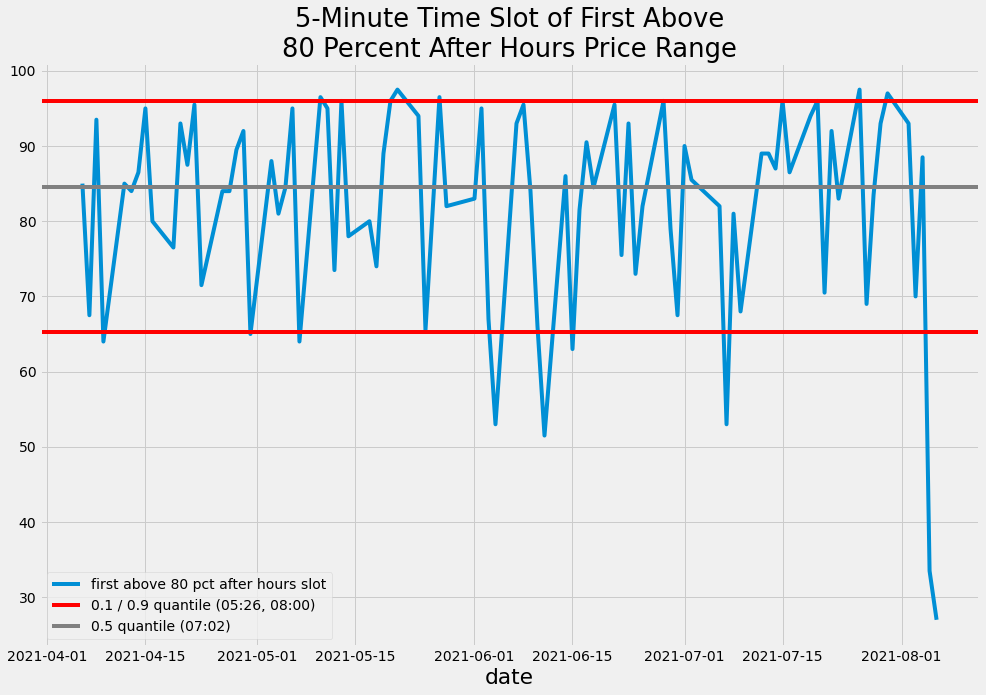

In [43]:
# median first_above_80_pct_after_hours_slot per day
median_per_day = train_df.first_above_80_pct_after_hours_slot.groupby(level=0).median()
median_per_day.plot(
    label=train_df.first_above_80_pct_after_hours_slot.name.replace('_', ' ')
)

quantile_9 = median_per_day.quantile(.9)
quantile_5 = median_per_day.quantile(.5)
quantile_1 = median_per_day.quantile(.1)

quantile_9_time = Wqu.time_to_str(Wqu.transform_5_minute_interval_to_time_since_close(quantile_9))
quantile_5_time = Wqu.time_to_str(Wqu.transform_5_minute_interval_to_time_since_close(quantile_5))
quantile_1_time = Wqu.time_to_str(Wqu.transform_5_minute_interval_to_time_since_close(quantile_1))

plt.axhline(quantile_9, color='red', label=f'0.1 / 0.9 quantile ({quantile_1_time}, {quantile_9_time})')
plt.axhline(quantile_5, color='grey', label=f'0.5 quantile ({quantile_5_time})')
plt.axhline(quantile_1, color='red')
plt.legend()
plt.title('5-Minute Time Slot of First Above\n80 Percent After Hours Price Range');

# save_plt_as_png('time_first_above_80_percent_after_hours_price_range')

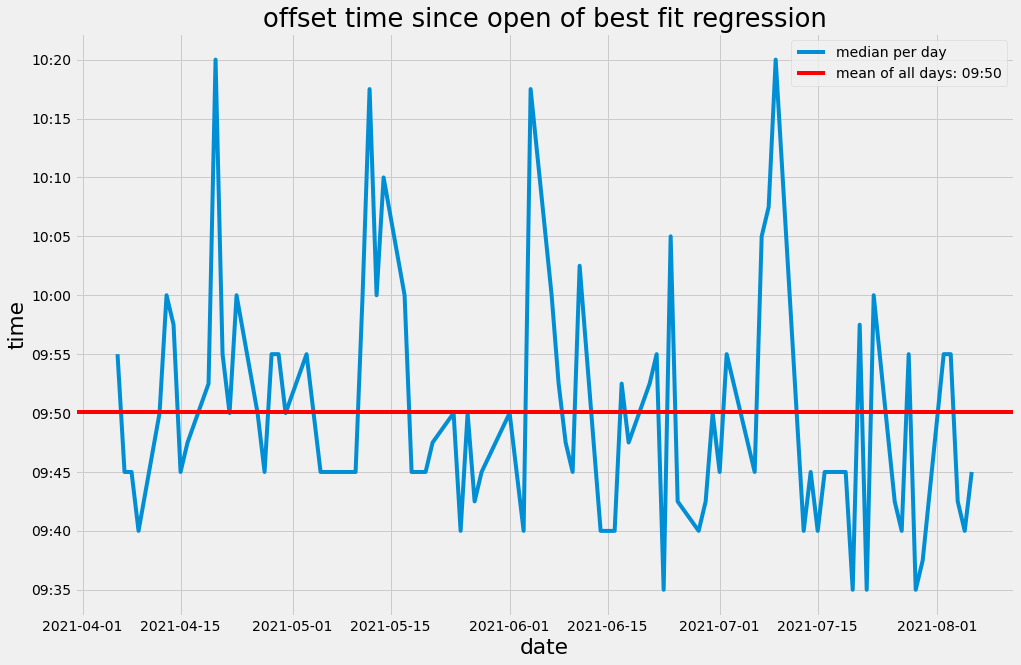

In [49]:
reg_fit_columns = per_day_median_best_fit_reg_time = \
    target_vars_all_stocks.filter(like='_fit').columns

per_day_median_best_fit_reg_time_numeric = \
    train_df[target_vars_all_stocks.columns].filter(like='_fit').apply(
        lambda row: row.argmax(), 
        axis=1
    ).groupby(level=0).median()

per_day_median_best_fit_reg_time = \
    per_day_median_best_fit_reg_time_numeric\
    .transform(Wqu.transform_numeric_offset_to_time_since_open)

mean_of_all_days = Wqu.transform_numeric_offset_to_time_since_open(
    per_day_median_best_fit_reg_time_numeric.mean()
)

ax = plt.subplot()
ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
per_day_median_best_fit_reg_time.plot(label='median per day', ax=ax)
ax.axhline(mean_of_all_days, color='r', label=f'mean of all days: {Wqu.time_to_str(mean_of_all_days)}')
ax.set_title('offset time since open of best fit regression')
ax.set_ylabel('time')
ax.legend();

# save_plt_as_png('offset_time_since_open_of_best_fit_regression')

In [51]:
max_price_change = pd.DataFrame({
    'max_pos_price_pct_change': train_df.max_pos_price_pct_change_since_open.values,
    'max_neg_price_pct_change': train_df.max_neg_price_pct_change_since_open.values * -1
}) * 100

max_price_change_melted = max_price_change.melt(var_name='type', value_name='pct_change')

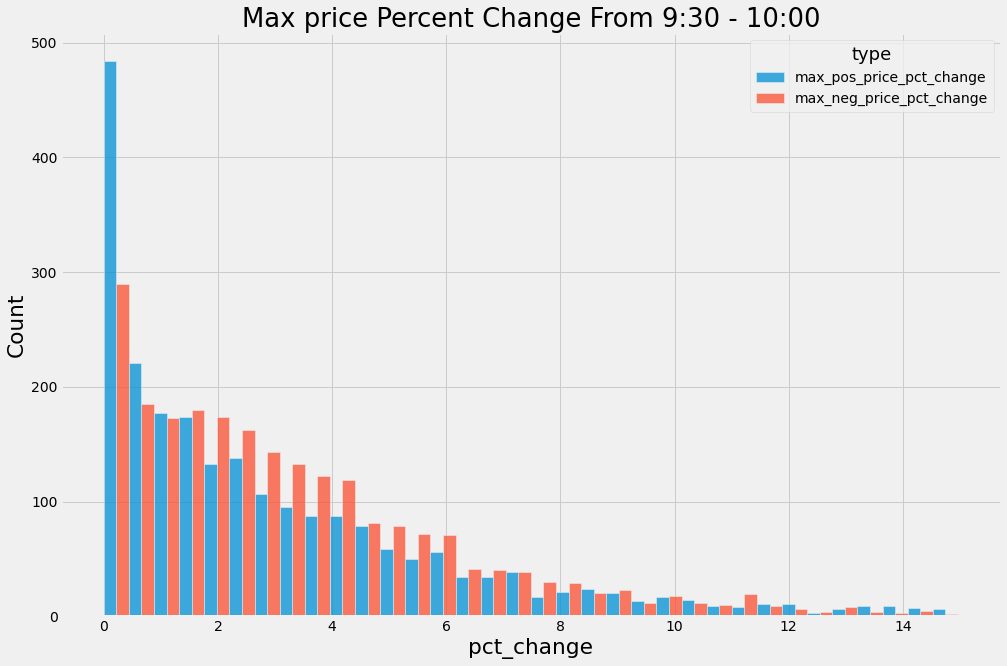

In [52]:
sns.histplot(
    data=max_price_change_melted[max_price_change_melted['pct_change'] < 15],
     x='pct_change',
    hue='type',
    multiple='dodge'
)
plt.title('Max price Percent Change From 9:30 - 10:00');
# save_plt_as_png('max_price_change_during_open')

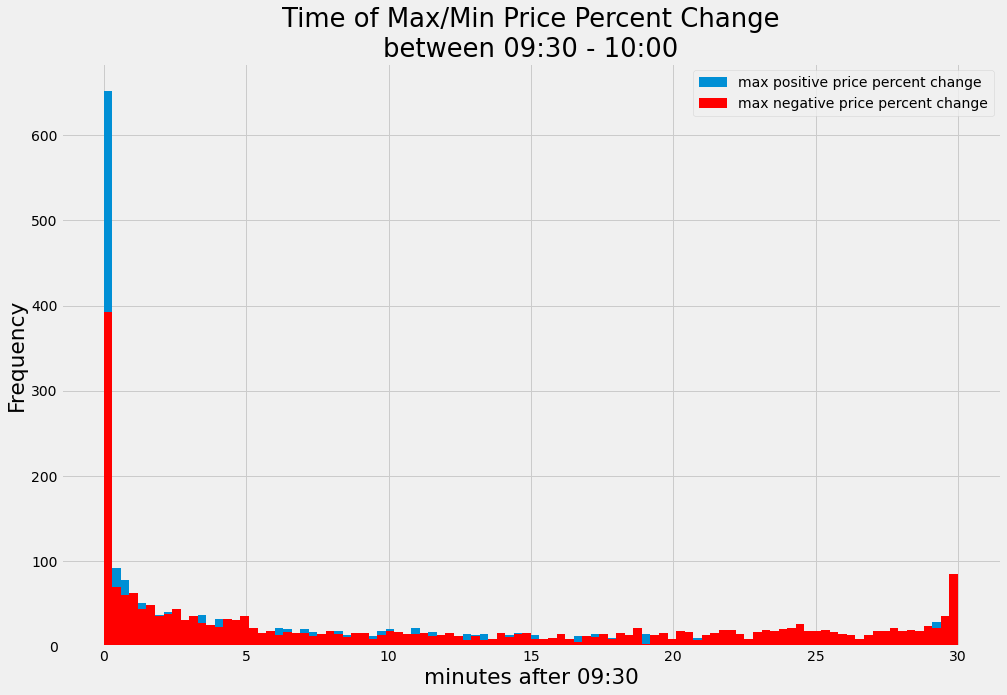

In [53]:
train_df.time_max_price_after_open_until_thresh_time.plot.hist(bins=100, label='max positive price percent change');
train_df.time_min_price_after_open_until_thresh_time.hist(bins=100, color='r', label='max negative price percent change')

plt.legend()
plt.xlabel('minutes after 09:30')
plt.title('Time of Max/Min Price Percent Change\nbetween 09:30 - 10:00');

# save_plt_as_png('time_of_max_min_price_percent_change_between_09:30_10:00')

we can see from the above plot that highest frequency of highest / lower prices for each stock occurs within the first minute after the open (however, this doesn't indicate that the stocks make large price moves; From this plot, it is possible that most stocks do not make any move and stay close to the opening price)

In [59]:
# ratio of na
ratio_na_pred_vars = train_df[pred_vars_all_stocks_df.columns].isna().sum() / len(train_df)

ratio_na_pred_vars.sort_values(ascending=False, inplace=True)
# save_html_to_png(ratio_na_pred_vars, 'ratio_na_pred_vars')
ratio_na_pred_vars.to_frame(name='ratio_na_pred_vars')

,ratio_na_pred_vars
dividend_$,0.854770
interest_income_$,0.541312
short_float_pct,0.239353
revenue_$_per_year,0.191227
year_daily_log_closes_reg_slope,0.143101
year_daily_log_closes_reg_fit,0.143101
cash_to_debt_ratio,0.136712
current_assets_$,0.099233
float,0.076235
cash_$,0.055792


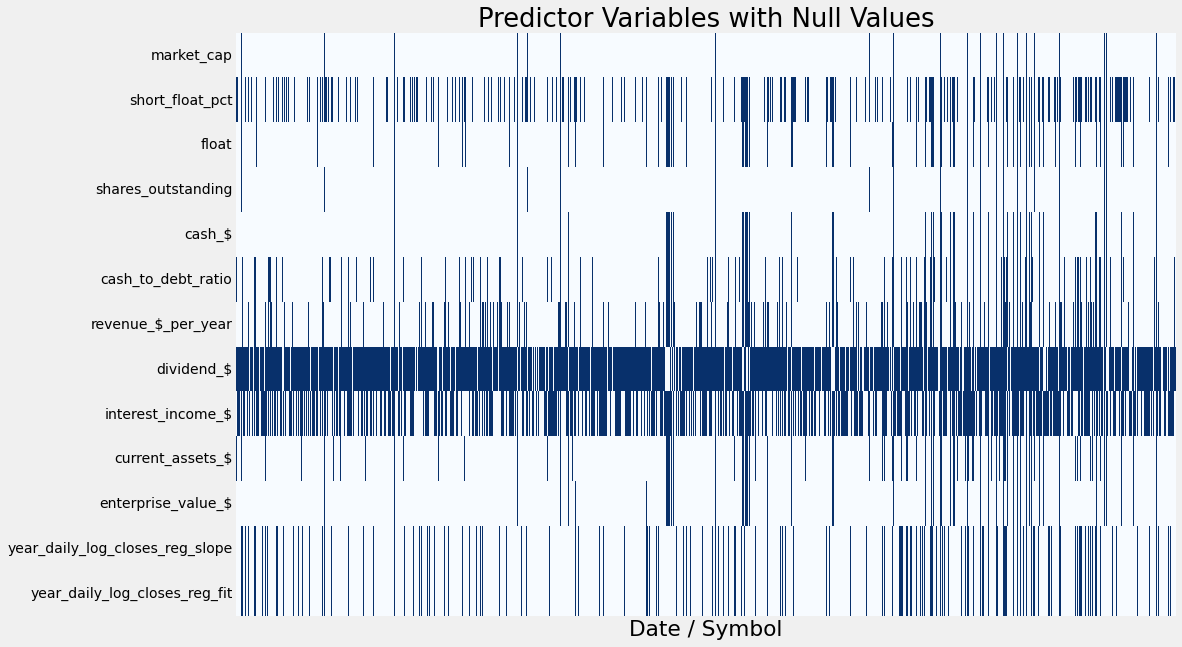

In [60]:
# null values
ax = sns.heatmap(
    train_df[pred_vars_all_stocks_df.columns].isna().iloc[:, train_df.isna().any()[pred_vars_all_stocks_df.columns].values].T, 
    cbar=False, cmap='Blues', xticklabels=False
);
ax.set_xlabel('Date / Symbol');
ax.set_title('Predictor Variables with Null Values');
# save_plt_as_png('na_pred_variables_visualization')

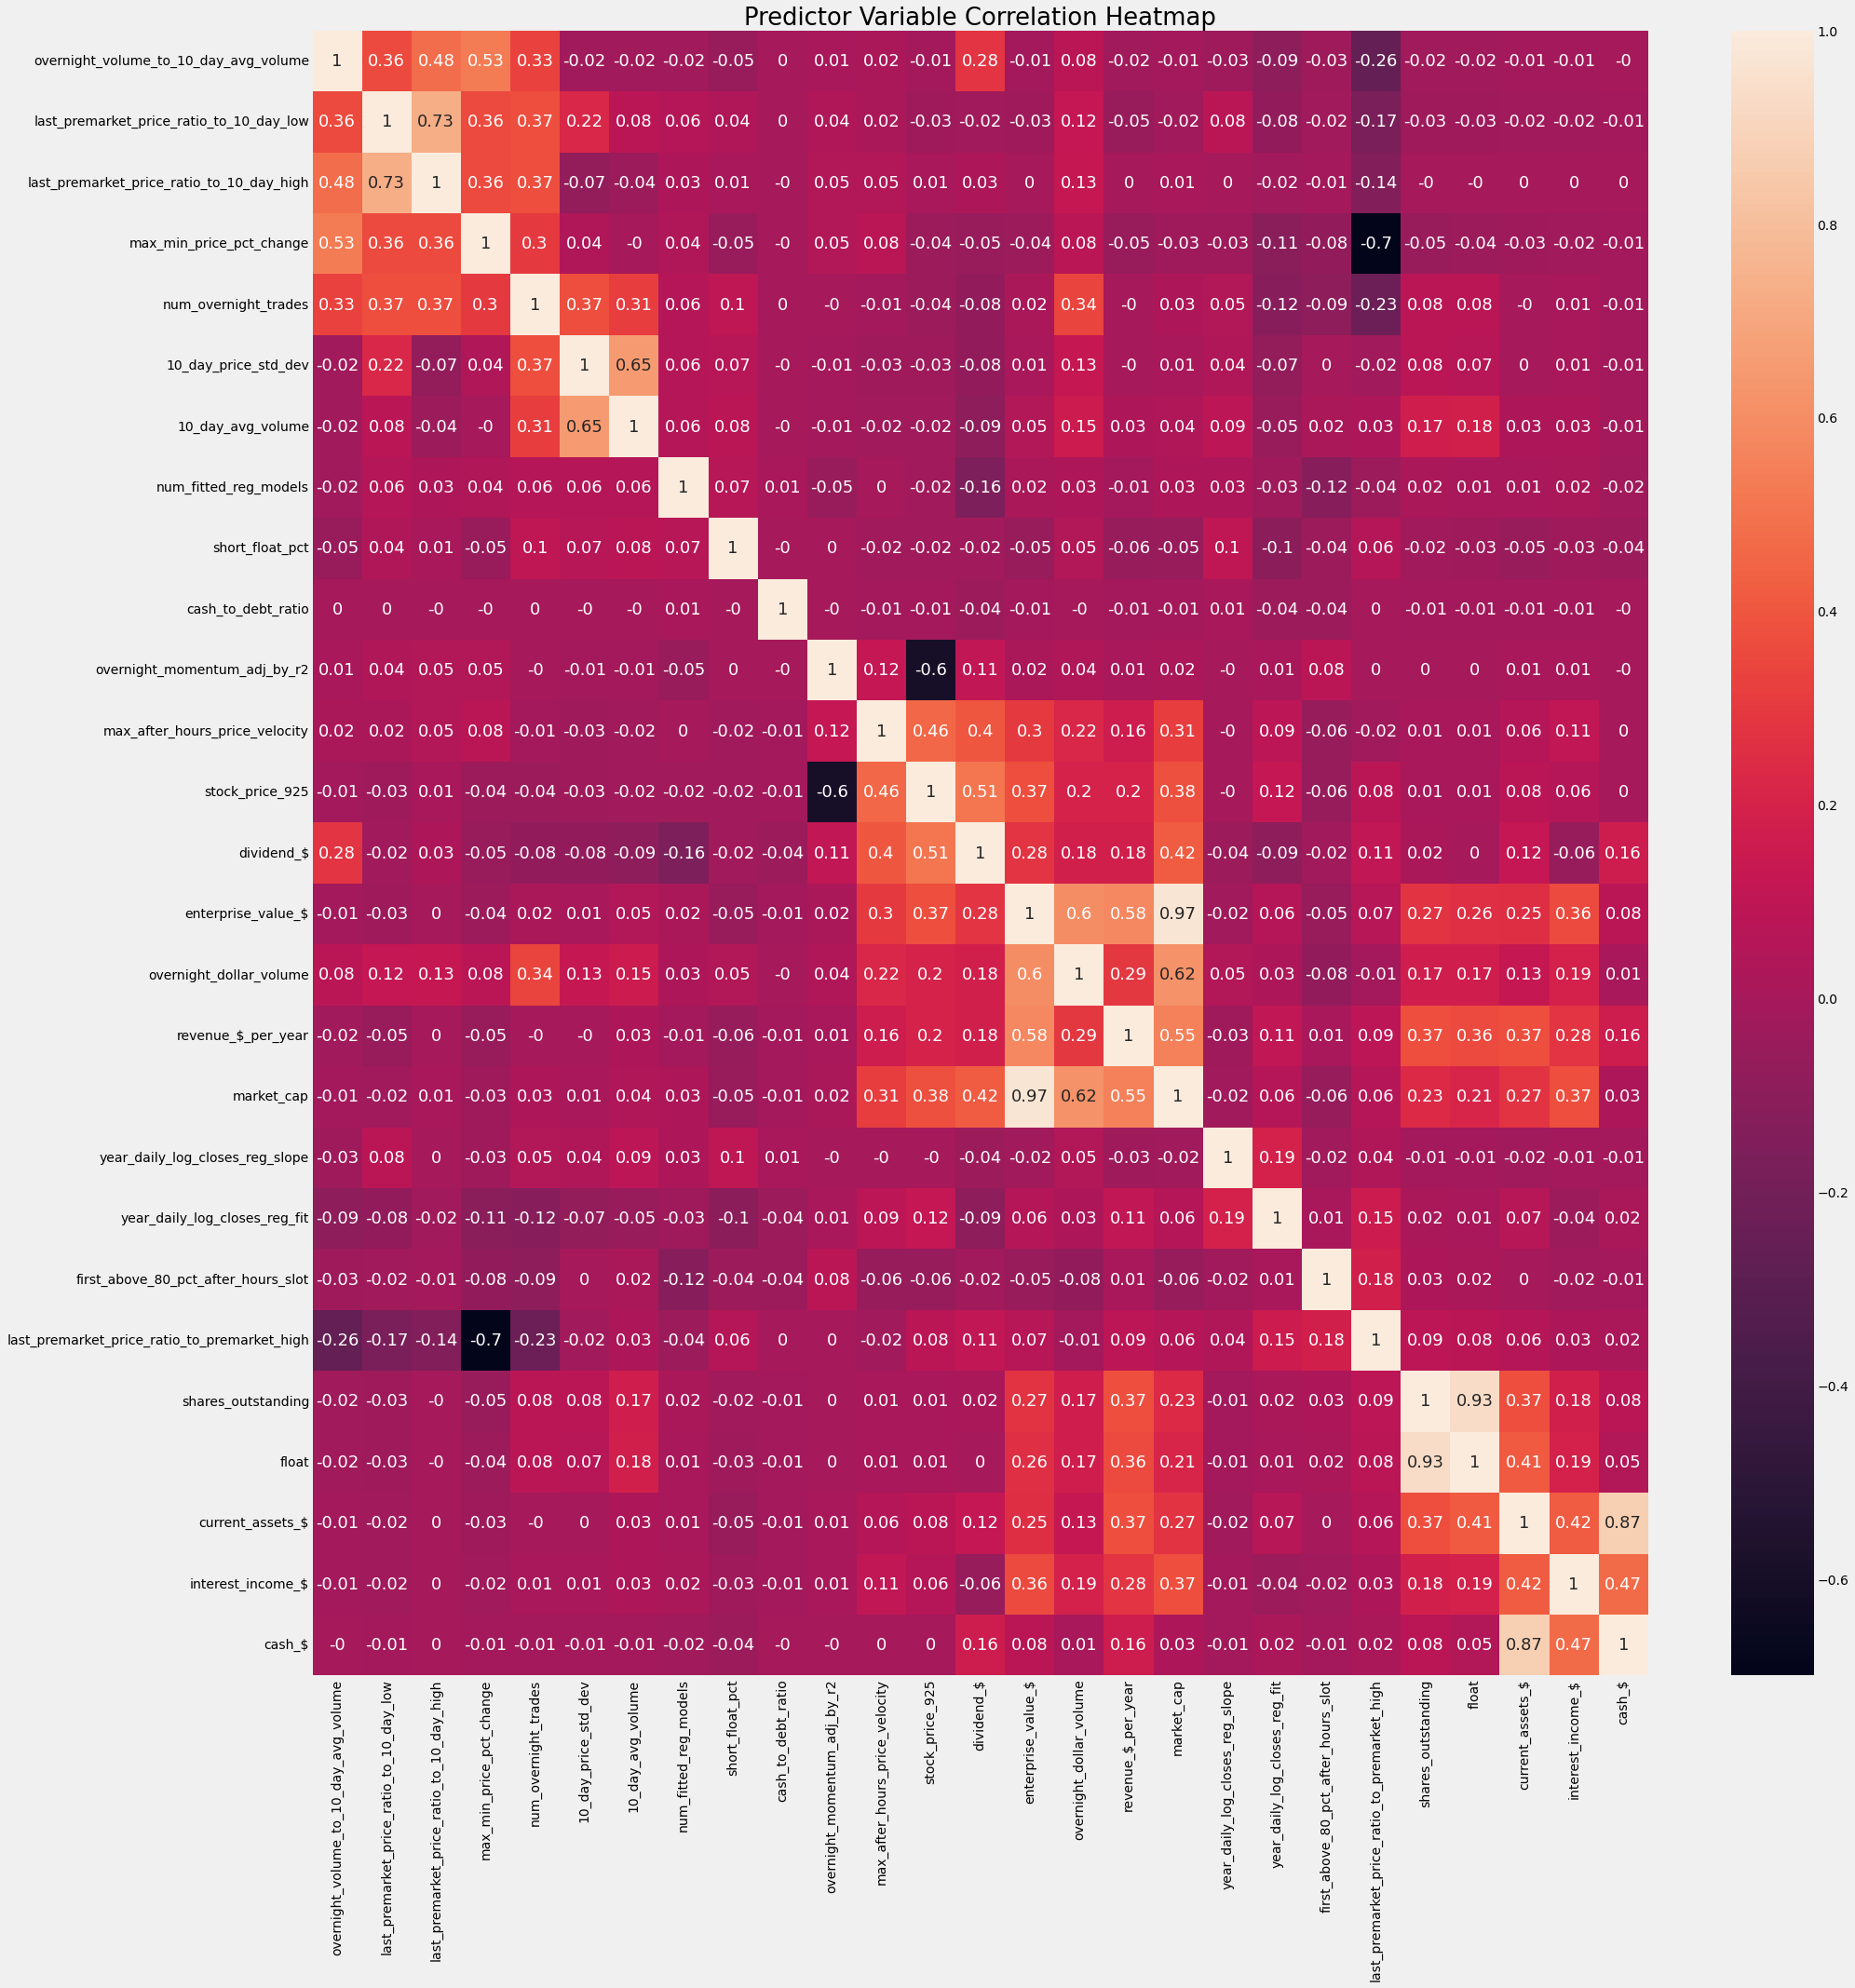

In [219]:
_, axis = plt.subplots(figsize=(30, 30))
corr = train_df[pred_vars_all_stocks_df.columns].corr().round(2)
sns.heatmap(Wqu.cluster_corr(corr), annot=True, ax=axis)
axis.set_title('Predictor Variable Correlation Heatmap');

# save_plt_as_png('predictor_variable_correlation_heatmap')

In [63]:
corr_pairs = \
    Wqu.get_highest_correlation_pairs(train_df[pred_vars_all_stocks_df.columns])

In [65]:
highest_corr_pairs = corr_pairs[abs(corr_pairs) >= 0.5].reset_index()
# save_html_to_png(highest_corr_pairs, 'highest_corr_pred_vars')
highest_corr_pairs

Generating to ../imgs/highest_corr_pred_vars.png...
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,predict_var_1,predict_var_2,corr
0,market_cap,enterprise_value_$,0.970163
1,float,shares_outstanding,0.934798
2,cash_$,current_assets_$,0.866381
3,last_premarket_price_ratio_to_10_day_high,last_premarket_price_ratio_to_10_day_low,0.733352
4,max_min_price_pct_change,last_premarket_price_ratio_to_premarket_high,0.697779
5,10_day_avg_volume,10_day_price_std_dev,0.648342
6,market_cap,overnight_dollar_volume,0.620837
7,stock_price_925,overnight_momentum_adj_by_r2,0.601979
8,enterprise_value_$,overnight_dollar_volume,0.596089
9,revenue_$_per_year,enterprise_value_$,0.577947


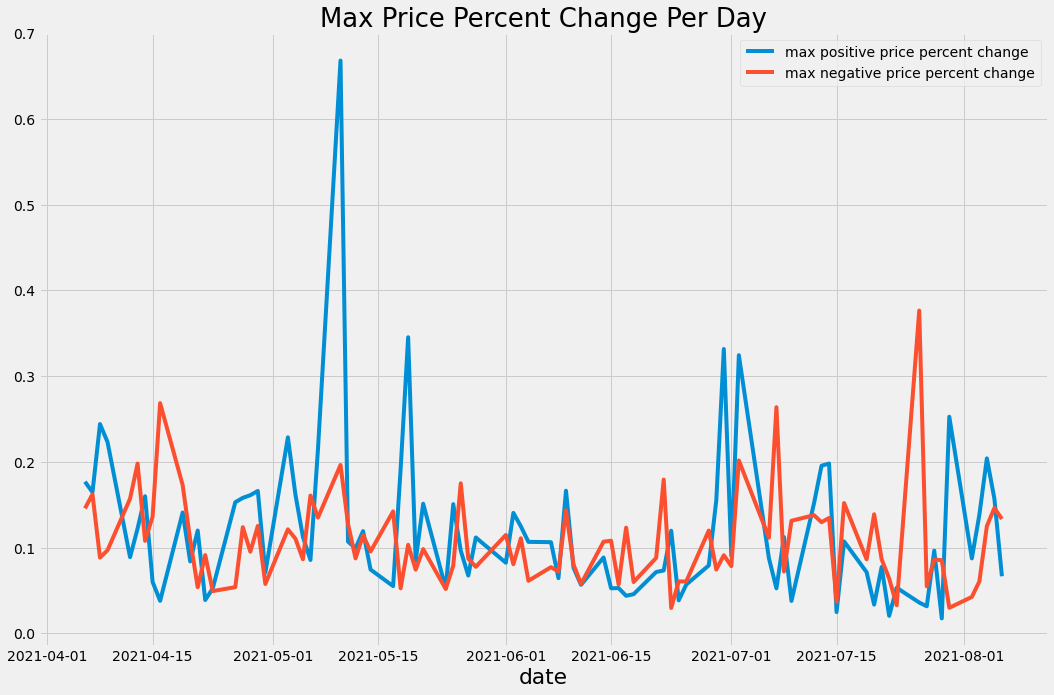

In [67]:
ret_col = '10:00_ret'
train_df[ret_col].groupby(level=0).max().plot(label='max positive price percent change');
train_df[ret_col].groupby(level=0).min().abs().plot(label='max negative price percent change');
# plt.axhline(0, color='grey', alpha=0.5);
plt.title('Max Price Percent Change Per Day')
plt.legend();

# save_plt_as_png('max_price_percent_change_per_day')

Since the goal of the trading strategy is to trade only stocks with an expected large move, i.e. expected price percentage change above a certain threshold, we will visualize how many stocks there are above a given price percent change threshold

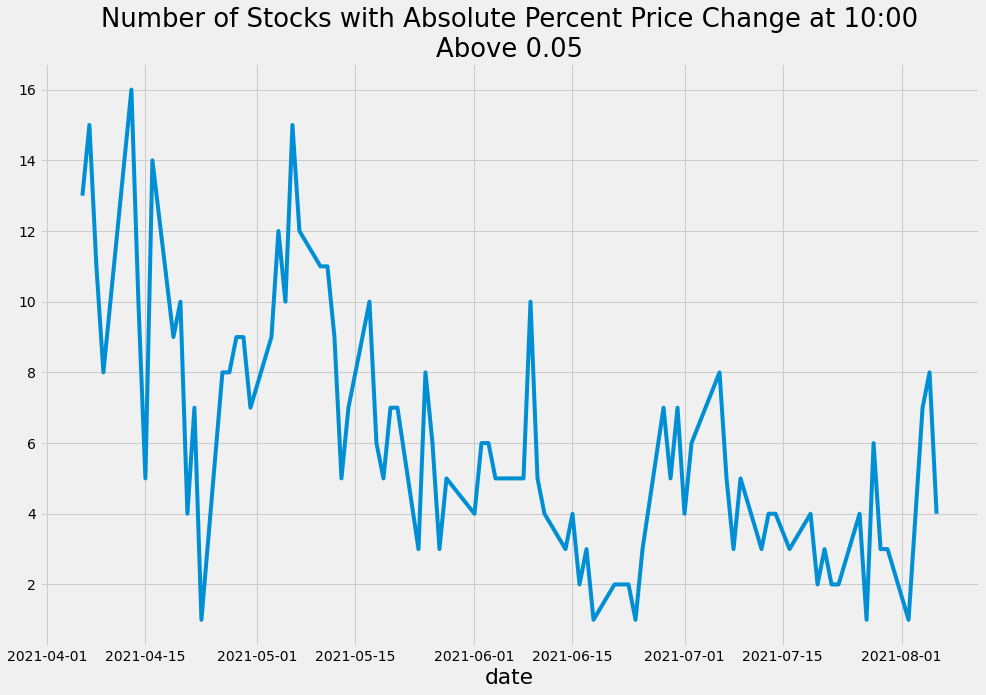

In [68]:
ret_col = '10:00_ret'
thresh = 0.05
(train_df[abs(train_df[ret_col]) >= thresh])[ret_col].groupby(level=0).size().plot()
plt.title(f'Number of Stocks with Absolute Percent Price Change at 10:00\nAbove {thresh}');

# save_plt_as_png(f'number_of_stocks_with_absolute_percent_price_change_at_10:00_above_{thresh}')

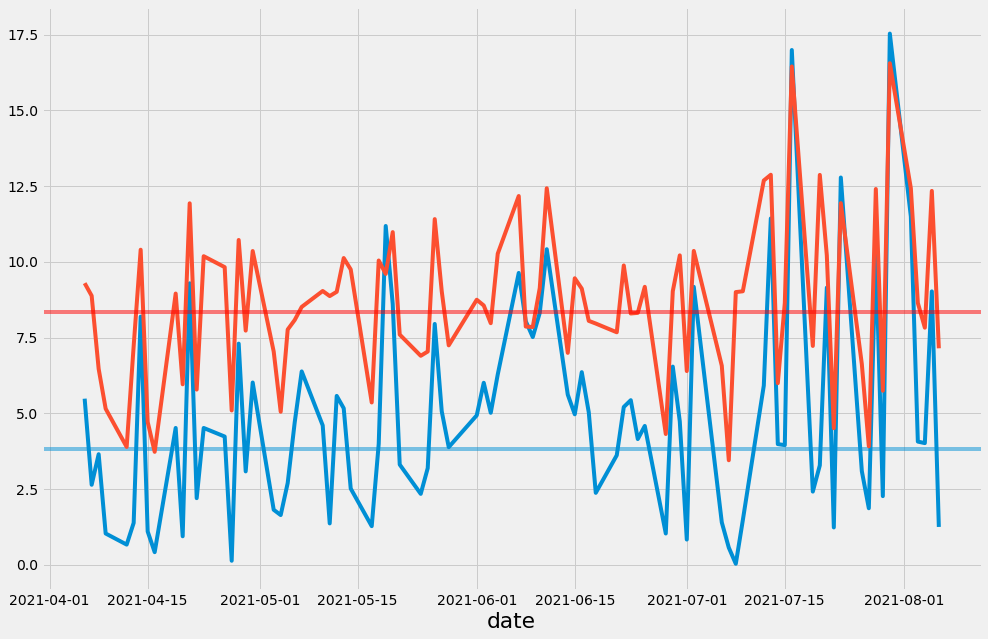

In [69]:
# not in paper

# median time of max price after open per day
train_df.time_max_price_after_open_until_thresh_time.groupby(level=0).median().plot()
plt.axhline(train_df.time_max_price_after_open_until_thresh_time.median(), alpha=0.5)

train_df.time_max_price_after_open_until_thresh_time.groupby(level=0).mean().plot()
plt.axhline(train_df.time_max_price_after_open_until_thresh_time.mean(), color='r', alpha=0.5);

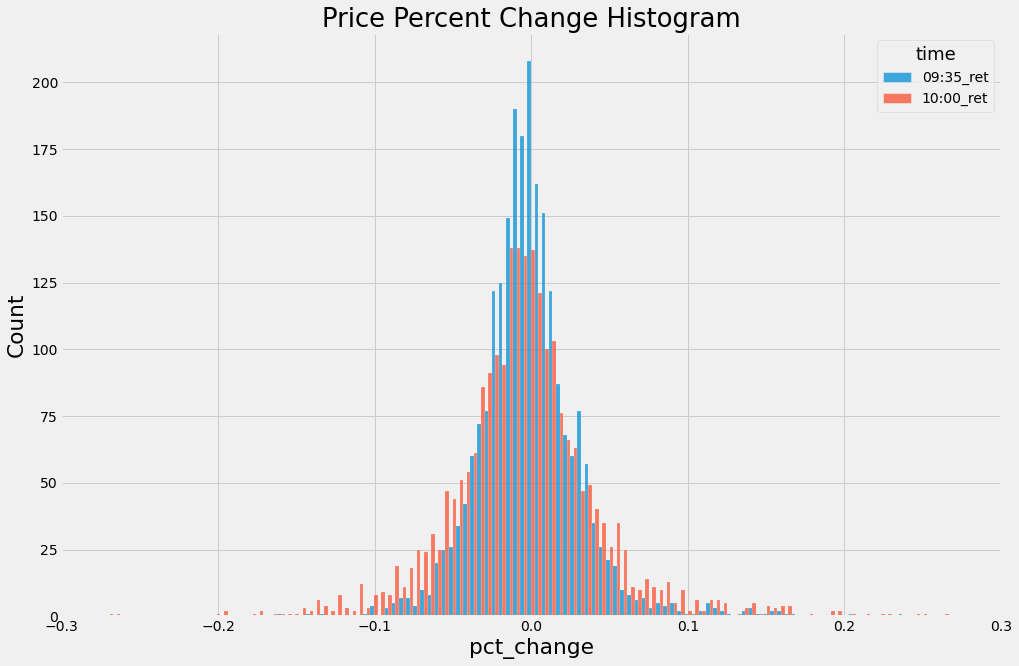

In [72]:
df_melted = train_df[['09:35_ret', '10:00_ret']].melt(var_name='time', value_name='pct_change')

sns.histplot(
    data=df_melted,
    x='pct_change',
    hue='time',
    multiple='dodge'
)
plt.xlim([-.3, .3])
plt.title('Price Percent Change Histogram');

# save_plt_as_png('price_percent_change_histogram')

In [22]:
df = train_df.filter(like='_ret').agg(["mean", "skew", 'kurtosis']).round(3)
df = df.rename(lambda s: s.replace('_', ' '), axis='columns')
# save_html_to_png(df, 'agg_stats_of_returns')
df

,09:35 ret,09:40 ret,09:45 ret,09:50 ret,09:55 ret,10:00 ret
mean,-0.001,-0.001,-0.002,-0.003,-0.004,-0.004
skew,0.936,1.604,2.278,1.972,1.797,1.368
kurtosis,5.336,11.673,18.036,17.543,19.645,16.664


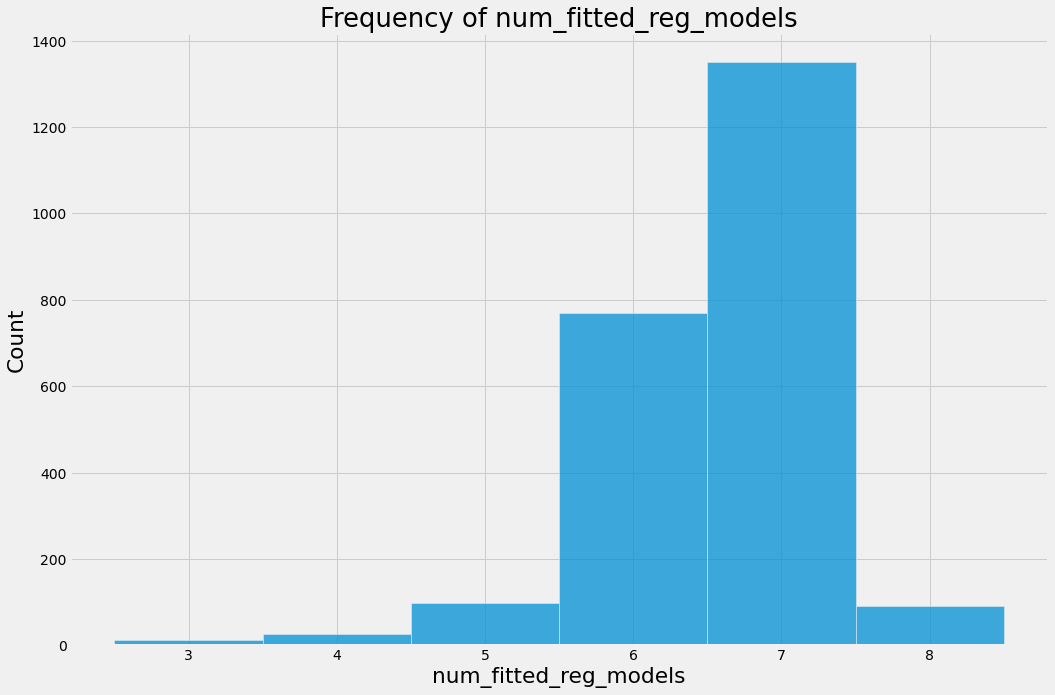

In [151]:
sns.histplot(
    data=train_df.num_fitted_reg_models,
    discrete=True
)
plt.title('Frequency of num_fitted_reg_models');

# save_plt_as_png('frequency_of_num_fitted_reg_models')

## Model building and Fitting

In [49]:
target_column = '09:35_ret'

In [50]:
def add_missing_ind_columns(df, columns_to_filter):
    columns_with_any_null_mask = df[columns_to_filter].isnull().any()
    columns_with_null = columns_to_filter[columns_with_any_null_mask]
    is_null_df = df.loc[:, columns_with_null].isnull().astype(int).add_suffix('_missing')
    return pd.concat([df, is_null_df])

In [77]:
X = train_df[pred_vars_all_stocks_df.columns].copy()

p = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(n_estimators=1_000, max_features='sqrt', n_jobs=32))
    ])
cv = KFold()

avg_reg_score_per_ret_time = []
for ret_column in target_vars_all_stocks.filter(like='_ret', axis=1).columns:
    y_temp = train_df[ret_column]
    X_temp = X[~y_temp.isna()]
    y_temp = y_temp.dropna()
    
    p.fit(X_temp, y_temp)
    scores = cross_val_score(p, X_temp, y_temp, scoring='neg_mean_squared_error', cv=cv, n_jobs=32)
    score = scores.mean()
    avg_reg_score_per_ret_time.append((ret_column, score))

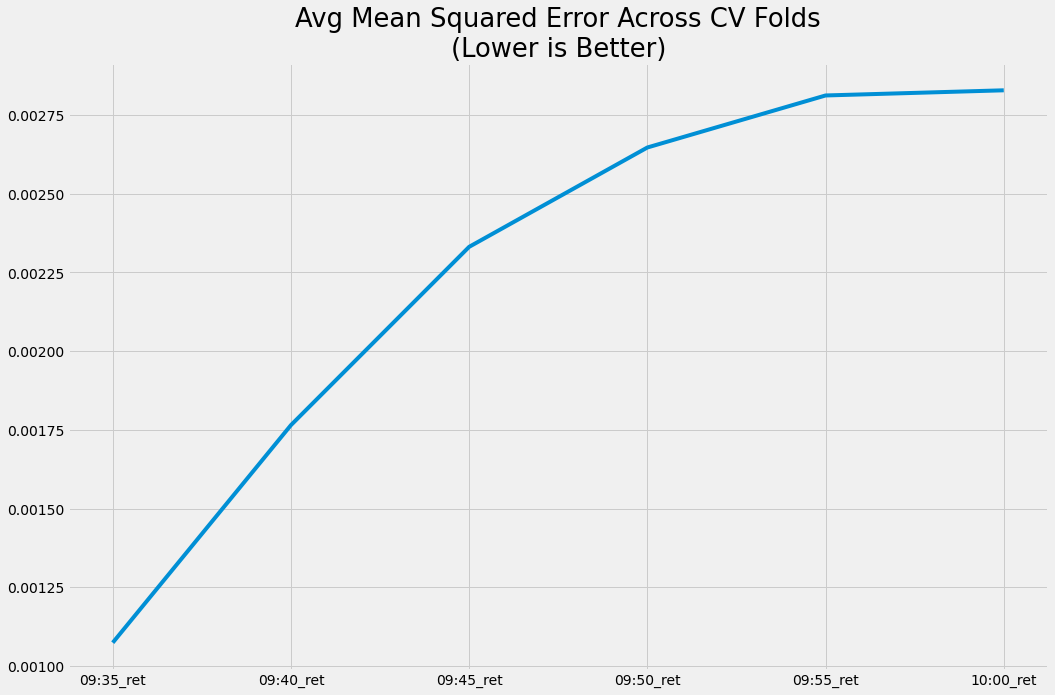

In [79]:
(pd.DataFrame(avg_reg_score_per_ret_time).set_index(0) * -1).plot(legend=None)
plt.xlabel(None)
plt.title('Avg Mean Squared Error Across CV Folds\n(Lower is Better)');

# save_plt_as_png('mean_squared_error_across_cv_folds')

confirming previous results that model predicting 9:35 is more accurate that predicting 10:00 price change

Now we check if varying the number of trees in the random forest model improves predictions

In [395]:
X, y = Wqu.drop_na_from_Xy_pair(
    train_df[pred_vars_all_stocks_df.columns],
    train_df[target_column]
)

cv = KFold()

scores_per_n_trees = []
for n_trees in range(1_000, 10_000+1, 500):
    p = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # sets na values to mean
        ('rf', RandomForestRegressor(n_estimators=n_trees, max_features='sqrt', n_jobs=32))
    ])
    p.fit(X, y)
    scores = cross_val_score(p, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=32)
    score = scores.mean()
    scores_per_n_trees.append((n_trees, score))

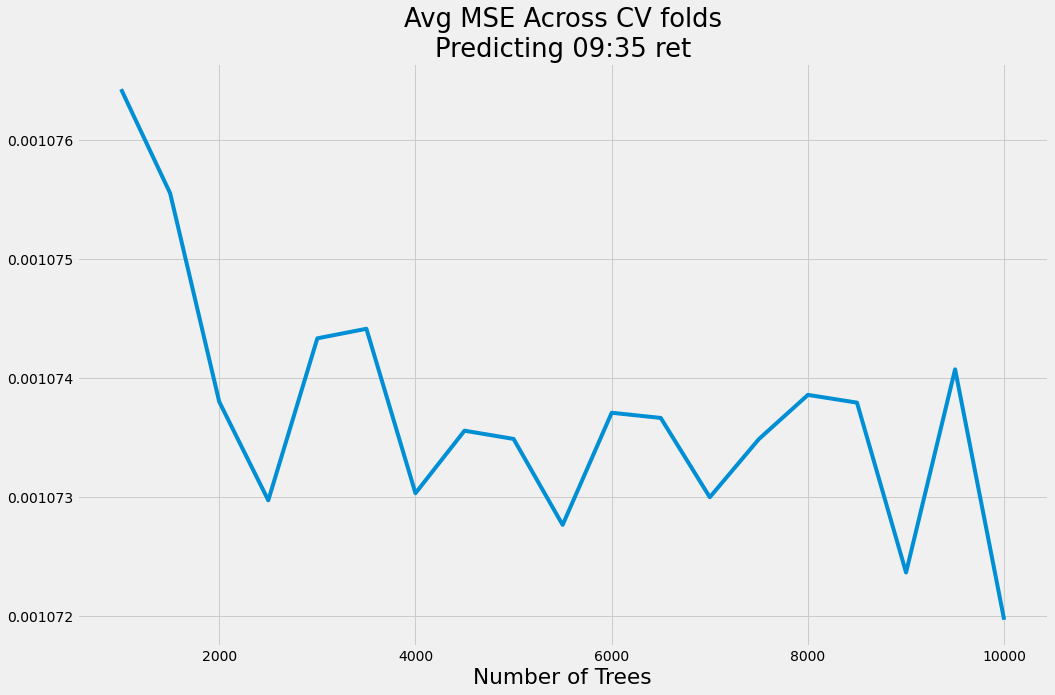

In [773]:
ax = plt.subplot()
(pd.DataFrame(scores_per_n_trees).set_index(0) * -1).plot(legend=None, ax=ax)
ax.set_title(f"Avg MSE Across CV folds\nPredicting {target_column.replace('_', ' ')}")
ax.set_xlabel('Number of Trees');

# save_plt_as_png('avg_mse_across_cv_folds')

The results don't plateau, probably due to the fact that financial data is noisy. We do see that MSE diminishes as number of trees increases, which is good. We will use 5,000 trees since more does not necessarily equate with better predictions due to high noise.

We now train different models per each return time series for use in testing in trading strategy - even though MSE is lower for 9:35 predictions
as opposed to 10:00 predictions, prices tend to make smaller moves in shorter times intervals, and hence profits from shorter trading might not cover trading slippage and commissions. Hence, we also try holding for longer periods, i.e. until 10:00.

In [59]:
X = train_df[pred_vars_all_stocks_df.columns]

return_columns = target_vars_all_stocks.filter(like='_ret', axis=1).columns

model_per_ret_time = {}
for ret_column in return_columns:
    X1, y1 = \
        Wqu.drop_na_from_Xy_pair(X, train_df[ret_column])
    
    reg_estimator = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='median')),
            ('rf', RandomForestRegressor(n_estimators=5_000, max_features='sqrt', n_jobs=32))
        ]
    )

    reg_estimator.fit(X1, y1)
    model_per_ret_time[ret_column] = reg_estimator

In [75]:
all_df_with_missing_col_indicators = add_missing_ind_columns(all_df, pred_vars_all_stocks_df.columns)
train_df_with_missing_col_indicators, test_df_with_missing_col_indicators = \
    Wqu.get_train_test(all_df_with_missing_col_indicators, test_start_date)

In [56]:
# train model which works on df with columns indicating if predictor values are NA

X = train_df_with_missing_col_indicators[pred_vars_all_stocks_df.columns]

X1, y1 = \
    Wqu.drop_na_from_Xy_pair(X, train_df_with_missing_col_indicators[target_column])

final_model_for_df_with_missing_ind_colums = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(n_estimators=5_000, max_features='sqrt', n_jobs=32))
    ]
)

final_model_for_df_with_missing_ind_colums.fit(X1, y1);

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', n_estimators=5000,
                                       n_jobs=32))])

In [61]:
# model predicting 9:35 returns has lowest MSE
final_model = model_per_ret_time[target_column]

In [109]:
# elastic net regression model

X = train_df_with_missing_col_indicators[pred_vars_all_stocks_df.columns]

X1, y1 = \
    Wqu.drop_na_from_Xy_pair(X, train_df_with_missing_col_indicators[target_column])

cv = KFold(n_splits=10, n_repeats=3, random_state=1)

en_cv = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
    alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0, 200, 300, 500, 1000], 
    cv=cv, 
    n_jobs=-32
)

elastic_net_model = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')),
        ('elastic_net', en_cv)
    ]
)

elastic_net_model.fit(X1, y1)

/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009840270096805437, tolerance: 0.00022558809091024026
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01330741135937119, tolerance: 0.00022567120019708993
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-pac

/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1195349035536084, tolerance: 0.0002277808175405917
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordina

/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1072489417378109, tolerance: 0.0002248452698923016
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.072362914466339, tolerance: 0.00021843335019123595
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages

/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.110596161764986, tolerance: 0.00022535978630793598
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: O

/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0563698104189159, tolerance: 0.00021578433594656268
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0559210151416802, tolerance: 0.00021578433594656268
  model = cd_fast.enet_coordinate_descent_gram(
/home/trade/.virtualenvs/trading-research/lib/python3.9/site-packag

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('elastic_net',
                 ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0,
                                      10.0, 100.0, 200, 300, 500, 1000],
                              cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                              n_jobs=-32))])

In [89]:
X, y = Wqu.drop_na_from_Xy_pair(
    test_df[pred_vars_all_stocks_df.columns],
    test_df[target_column]
)

test_df_missing_ind_columns = add_missing_ind_columns(test_df, pred_vars_all_stocks_df.columns)

X_missing_ind_cols, y_missing_ind_cols = Wqu.drop_na_from_Xy_pair(
    test_df_missing_ind_columns[pred_vars_all_stocks_df.columns],
    test_df_missing_ind_columns[target_column]
)

# out of sample
print('test scores')
print('MSE for vanilla final model', final_model.score(X, y))
print('MSE for final model with columns added for missing predictor variables', 
     final_model_for_df_with_missing_ind_colums.score(X_missing_ind_cols, y_missing_ind_cols))
print('MSE for elastic net model', elastic_net_model.score(X_missing_ind_cols, y_missing_ind_cols))

test scores
MSE for vanilla final model -0.034468659320009865
MSE for final model with columns added for missing predictor variables -0.03102613113413022
MSE for elastic net model -0.0036429710688243855


In [804]:
X, y = Wqu.drop_na_from_Xy_pair(
    train_df[pred_vars_all_stocks_df.columns],
    train_df[target_column]
)

num_pred_vars = len(pred_vars_all_stocks_df.columns)

# across max_features with values: 5, 10, 15, 20, 25 
scores_per_max_features = []
for max_features in np.arange(int(np.sqrt(num_pred_vars)), num_pred_vars+1, 5):
    p = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('rf', RandomForestRegressor(n_estimators=5_000, max_features=max_features, n_jobs=32))
    ])
    p.fit(X, y)
    scores = cross_val_score(p, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=32)
    score = scores.mean()
    scores_per_max_features.append((max_features, score))

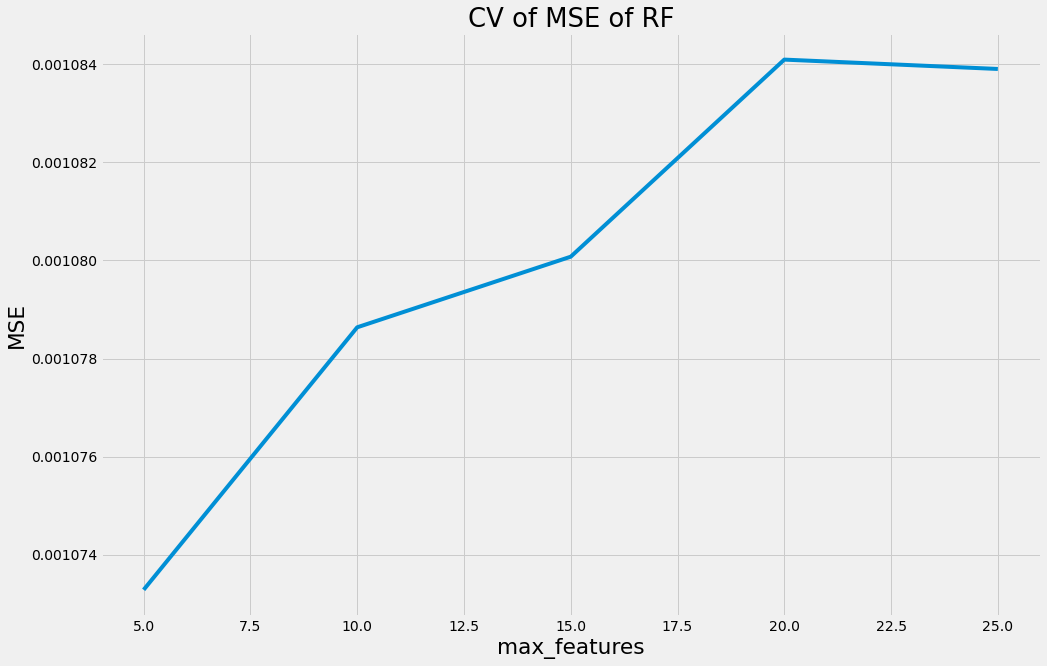

In [810]:
ax = plt.subplot()
(pd.DataFrame(scores_per_max_features).set_index(0) * -1).plot(legend=None, ax=ax);
plt.title('CV of MSE of RF')
ax.set_ylabel('MSE')
ax.set_xlabel('max_features');

## (Binary predictions not in final report)

In [315]:
def get_incorrect_side_predictions(y, y_predicted, thresh):
    # conditional distribution of correct side prediction
    
    thresh = abs(thresh)
    
    incorrect_side_predictions = pd.DataFrame(y)
    incorrect_side_predictions = incorrect_side_predictions * 100
    incorrect_side_predictions.loc[((y_predicted > thresh) & (y > thresh)) | ((y_predicted < -1 * thresh) & (y < -1 * thresh)), 'side'] = 'correct'
    incorrect_side_predictions.loc[((y_predicted < -1 * thresh) & (y > thresh)) | ((y_predicted > thresh) & (y < -1 * thresh)), 'side'] = 'incorrect'
    incorrect_side_predictions.dropna(inplace=True)
    
    return incorrect_side_predictions

In [324]:
# conditional distribution of correct side prediction
incorrect_side_predictions = get_incorrect_side_predictions(y2, reg_tree.predict(X2), 0)
incorrect_side_predictions

10am_ret       side
date       symbol                      
2021-07-12 STFC     0.578142    correct
           TPST   -13.772791  incorrect
           SGOC    15.158958  incorrect
           CLDX    -2.501174    correct
           PHVS     1.095557    correct
...                      ...        ...
2021-08-06 MTW     -3.512174  incorrect
           CNDT    -0.146843  incorrect
           ELMS    -4.224419    correct
           CYTO    -1.090343    correct
           EXEL    -3.303720    correct

[324 rows x 2 columns]

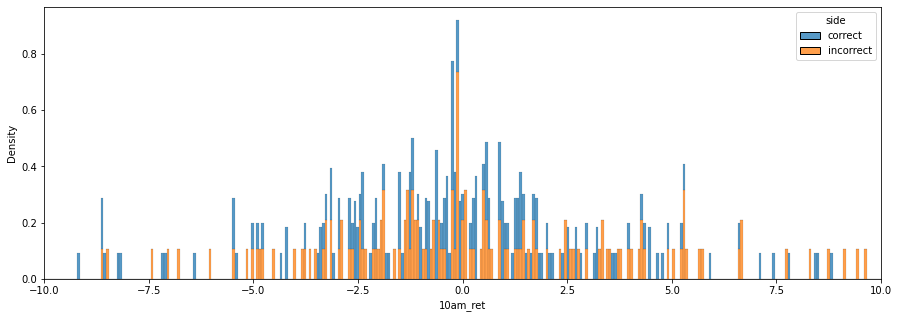

In [325]:
_, ax = plt.subplots(figsize=(15,5))
sns.histplot(
    x=incorrect_side_predictions['10:00_ret'], 
    hue=incorrect_side_predictions['side'], 
    bins=1000,
    stat='density', 
    common_norm=False, 
    multiple='stack', 
    ax=ax
)
plt.xlim(-10, 10);

In [327]:
incorrect_kurt = incorrect_side_predictions[target_column][incorrect_side_predictions['side'] == 'incorrect'].kurtosis()
correct_kurt = incorrect_side_predictions[target_column][incorrect_side_predictions['side'] == 'correct'].kurtosis()

incorrect_std = incorrect_side_predictions[target_column][incorrect_side_predictions['side'] == 'incorrect'].std()
correct_std = incorrect_side_predictions[target_column][incorrect_side_predictions['side'] == 'correct'].std()


print('incorrect excess kurt:', incorrect_kurt)
print('correct excess kurt:', correct_kurt)
print()
print('incorrect std:', incorrect_std)
print('correct std:', correct_std)

incorrect excess kurt: 4.687103243565558
correct excess kurt: 12.749592589737908

incorrect std: 5.375292448499145
correct std: 5.468728894262524


In [68]:
def plot_actual_vs_predicted_reg(actual, predicted, cls_map=None, ax_limit=0.5, title=None):
    dict_built = {
        'actual': actual,
        'predicted': predicted
    }
    
    plot_kwargs = dict(x='actual', y='predicted')
    
    if cls_map is not None:
        dict_built['class'] = cls_map
        plot_kwargs['hue'] = 'class'
    
    df = pd.DataFrame(dict_built)
    
    sns.scatterplot(data=df, **plot_kwargs)
    
    ax_limits = [-1 * ax_limit, 1 * ax_limit]
    plt.xlim(ax_limits)
    plt.ylim(ax_limits)

    # diagnal line
    plt.plot(
        [0, 1], [0, 1], 
        transform=plt.gcf().get_axes()[0].transAxes,
        color='black',
        linewidth=.9,
        alpha=0.25,
        linestyle='--'
    )
    
    if title is not None:
        plt.title(title)

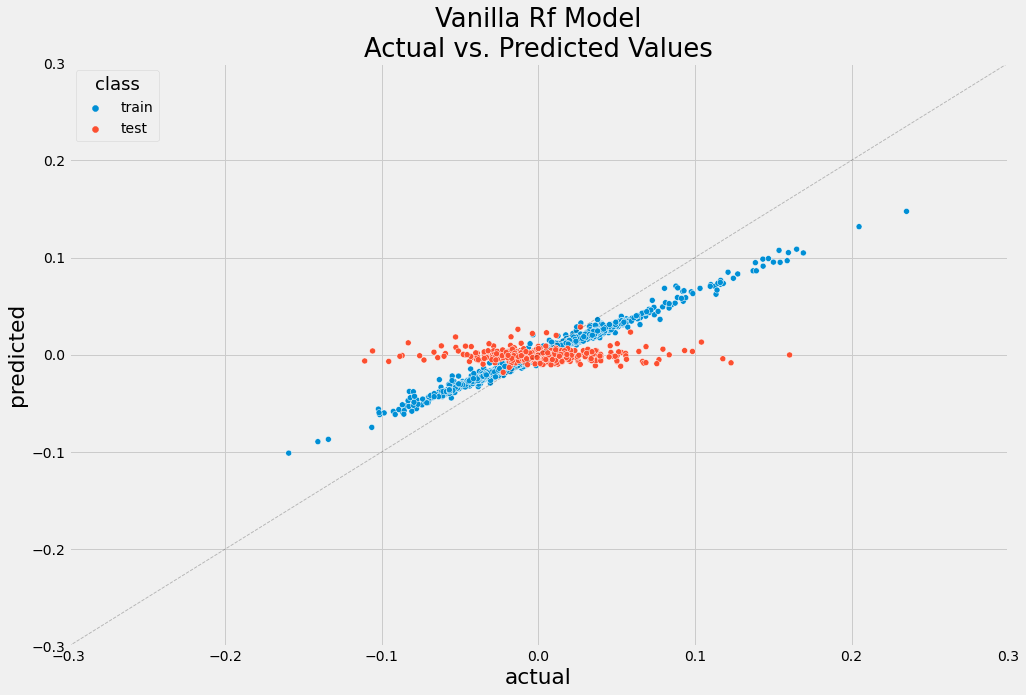

In [94]:
# vanilla final model

X, y = Wqu.drop_na_from_Xy_pair(
    all_df[pred_vars_all_stocks_df.columns],
    all_df[target_column]
)

s = pd.Series(dtype=str, index=X.index)
s[X.index.get_level_values(0) >= test_start_date] = 'test'
s[X.index.get_level_values(0) < test_start_date] = 'train'

plot_actual_vs_predicted_reg(
    y, 
    final_model.predict(X), 
    s, 
    ax_limit=0.3, 
    title='Vanilla Rf Model\nActual vs. Predicted Values'
)

# save_plt_as_png('model_predictions_actual_vs_predicted_values')

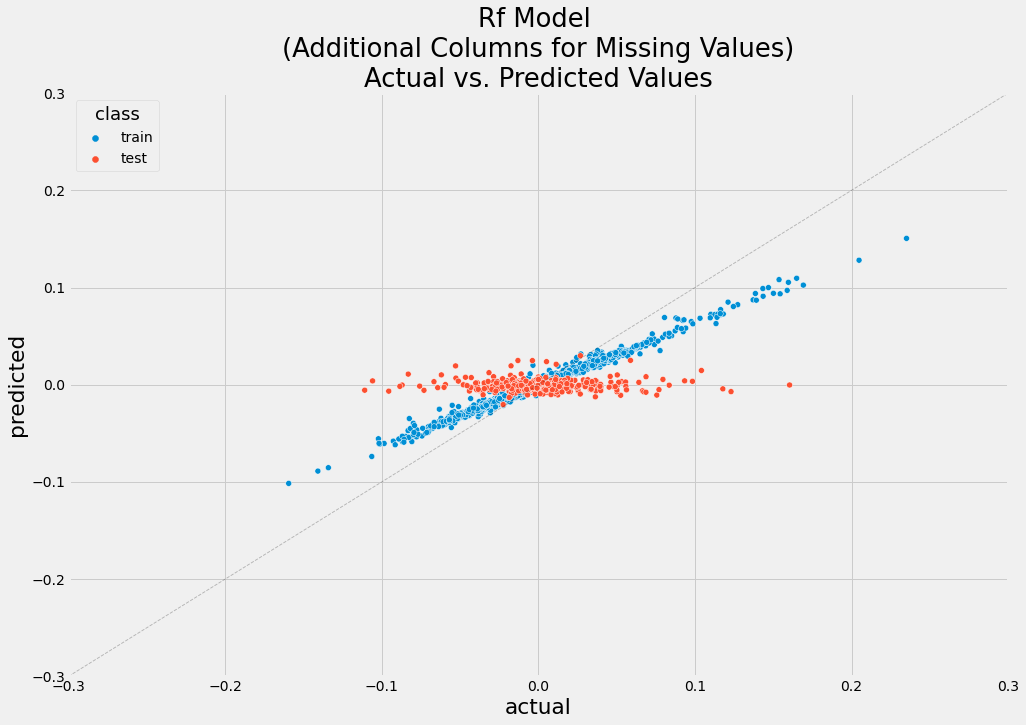

In [93]:
X, y = Wqu.drop_na_from_Xy_pair(
    all_df_with_missing_col_indicators[pred_vars_all_stocks_df.columns],
    all_df_with_missing_col_indicators[target_column]
)

s = pd.Series(dtype=str, index=X.index)
s[X.index.get_level_values(0) >= test_start_date] = 'test'
s[X.index.get_level_values(0) < test_start_date] = 'train'

plot_actual_vs_predicted_reg(
    y, 
    final_model_for_df_with_missing_ind_colums.predict(X), 
    s, 
    ax_limit=0.3, 
    title='Rf Model \n(Additional Columns for Missing Values)\nActual vs. Predicted Values'
)

# save_plt_as_png('model_predictions_actual_vs_predicted_values')

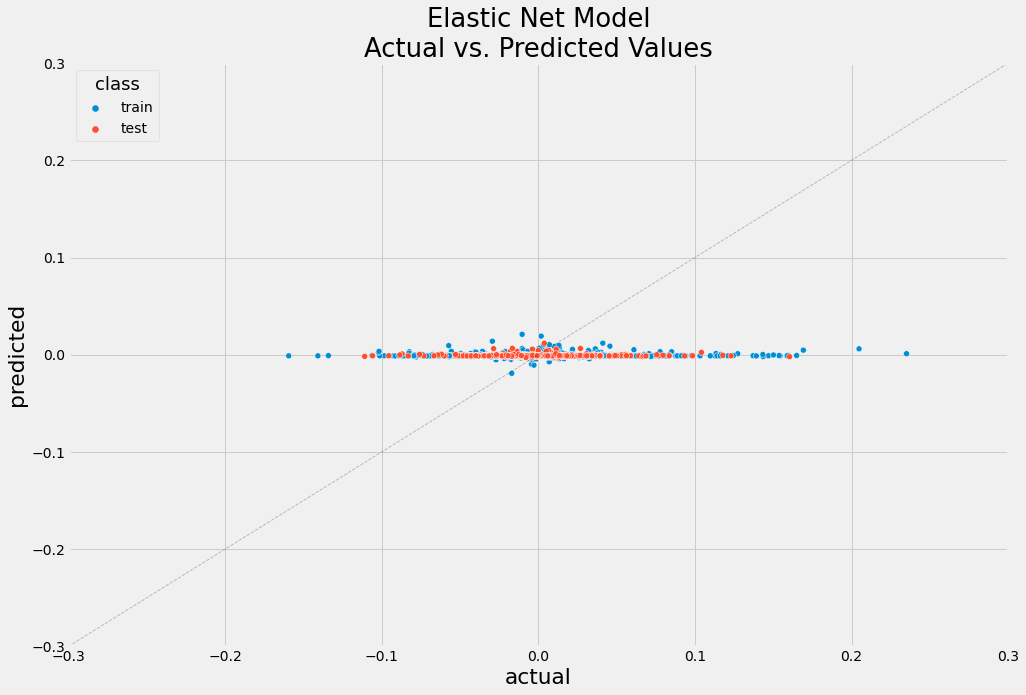

In [124]:
X, y = Wqu.drop_na_from_Xy_pair(
    all_df_with_missing_col_indicators[pred_vars_all_stocks_df.columns],
    all_df_with_missing_col_indicators[target_column]
)

s = pd.Series(dtype=str, index=X.index)
s[X.index.get_level_values(0) >= test_start_date] = 'test'
s[X.index.get_level_values(0) < test_start_date] = 'train'

plot_actual_vs_predicted_reg(
    y, 
    elastic_net_model.predict(X), 
    s, 
    ax_limit=0.3, 
    title='Elastic Net Model\nActual vs. Predicted Values'
)

# save_plt_as_png('model_predictions_actual_vs_predicted_values')

In [87]:
X, y = Wqu.drop_na_from_Xy_pair(
    test_df[pred_vars_all_stocks_df.columns],
    test_df[target_column]
)

tree_perm_importance = \
    permutation_importance(
        final_model, 
        X, 
        y, 
        scoring='neg_mean_squared_error',
        n_repeats=5
    )

In [88]:
feature_imp_series = pd.Series(
    tree_perm_importance.importances_mean, 
    index=X.columns
)
feature_imp_series.sort_values(ascending=False, inplace=True)

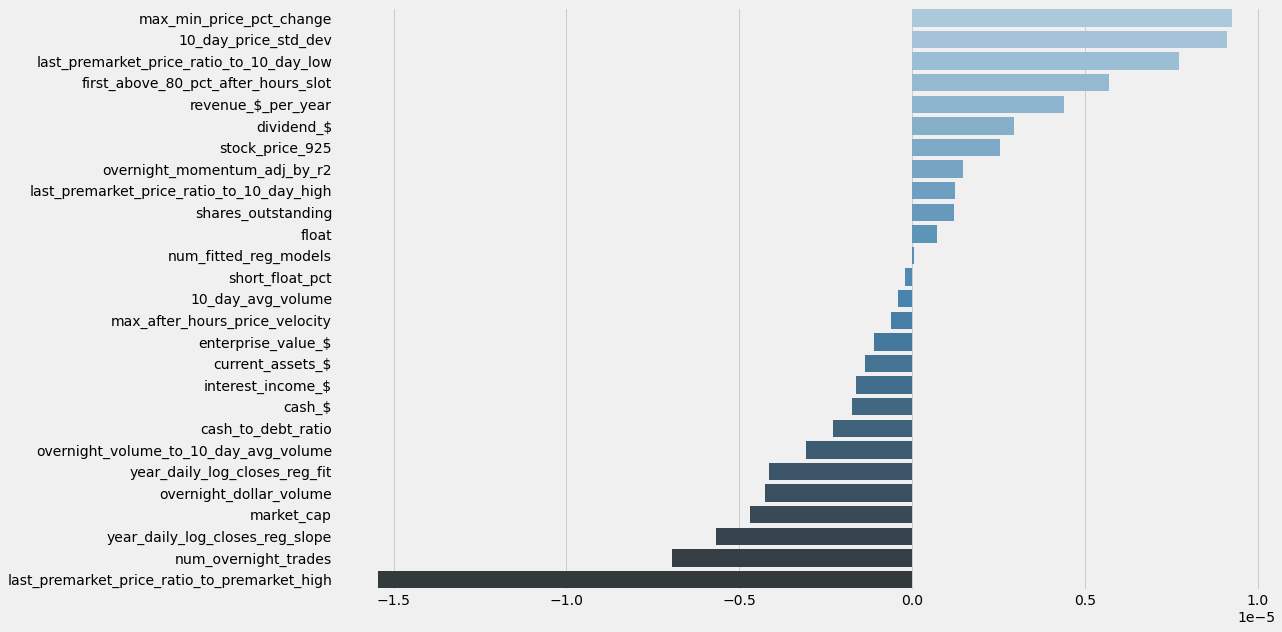

In [89]:
sns.barplot(
    y=feature_imp_series.index,
    x=feature_imp_series.values,
    palette="Blues_d"
);

# save_plt_as_png('feature_imp_oos')

## Trading Strategy

In [90]:
X, _ = Wqu.drop_na_from_Xy_pair(
    all_df[pred_vars_all_stocks_df.columns],
    all_df[target_column]
)

df = all_df[target_vars_all_stocks.columns].loc[X.index]

In [93]:
# simulate PnL across different exit times; 
# each exit time is tested with different min predicted thresh before opening a trade

bt_results_per_exit_time = []
exit_times = [dt.time(9,35), dt.time(9,40), dt.time(9,55), dt.time(10,0)]
for exit_time in exit_times:
    tmp_bt_results = backtest_model_per_exit_time = Wqu.backtest_model(
        df=df,
        ret_time=exit_time,
        model_per_ret_time=model_per_ret_time,
        X=X
    )
    bt_results_per_exit_time.append(tmp_bt_results)

min_pred_thresh_for_trade: 0.19min_pred_thresh_for_trade:
 starting capital:0.18 
starting capital:100000 100000

ending capital:ending capital:  100000100000

No trades executedNo trades executed

min_pred_thresh_for_trade:min_pred_thresh_for_trade: 0.2 
0.17
starting capital: starting capital:min_pred_thresh_for_trade:100000
  0.16ending capital:100000
 
starting capital:100000ending capital:
  100000100000No trades executed


ending capital:No trades executed 
100000
No trades executed
min_pred_thresh_for_trade: 0.15
starting capital: 100000min_pred_thresh_for_trade:
 ending capital:0.14
 starting capital:105606.40316831683 100000

ending capital: 105606.40316831683
min_pred_thresh_for_trade: 0.13
starting capital: 100000
ending capital: 105606.40316831683
min_pred_thresh_for_trade: 0.12
starting capital: 100000
ending capital: 110646.6407920792
min_pred_thresh_for_trade: 0.11
starting capital: 100000
ending capital: 113266.5691089109
min_pred_thresh_for_trade: 0.1
starting capital:

In [94]:
# bt_results_per_exit_time = cache.pickle_load('bt_results_per_exit_time.pickle')

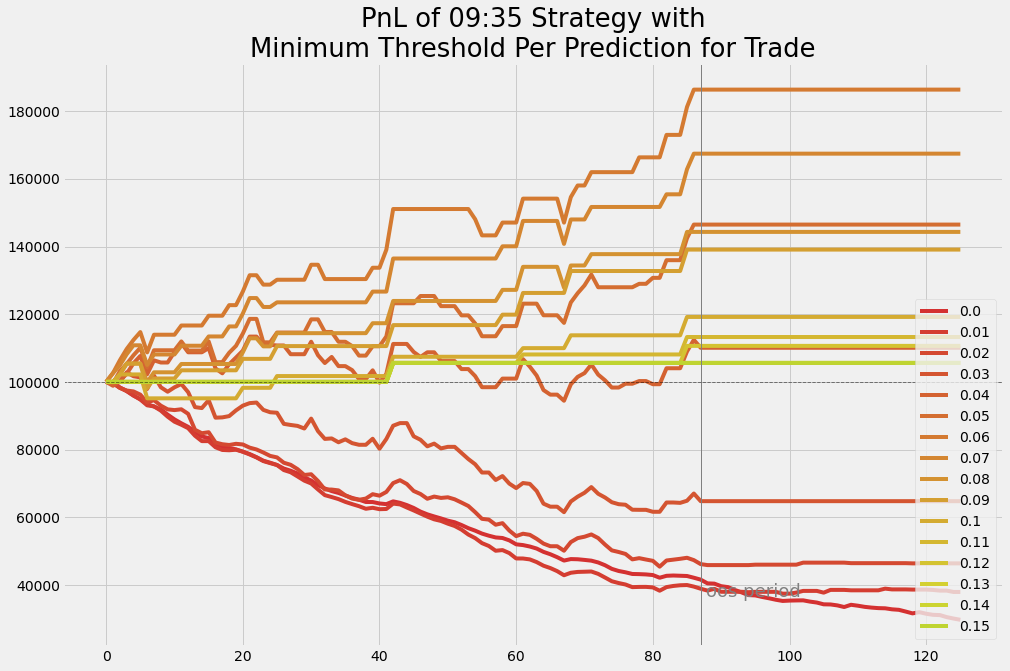

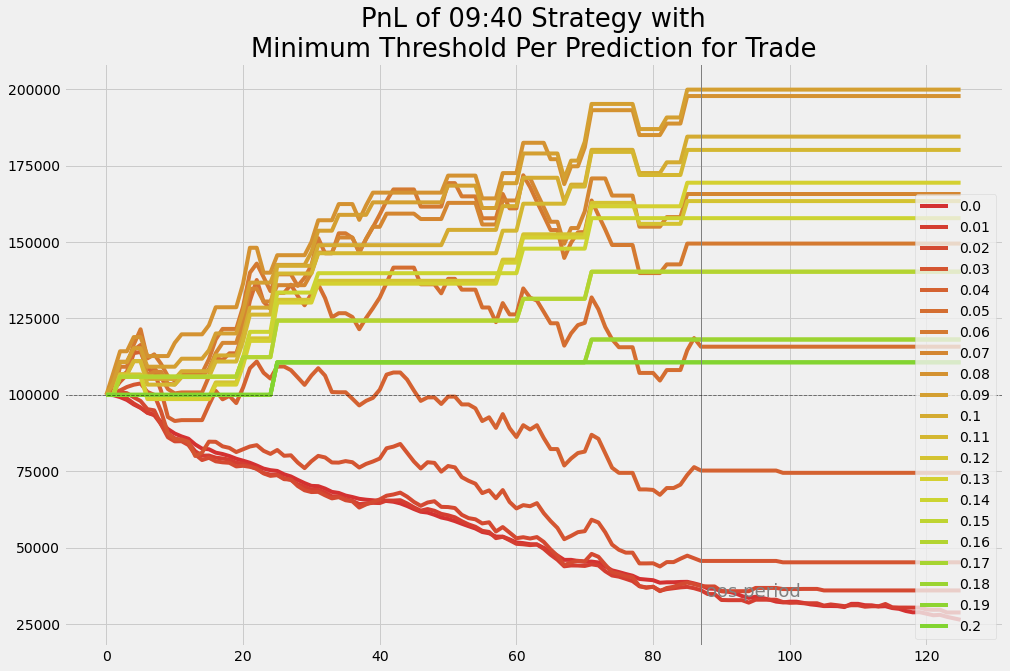

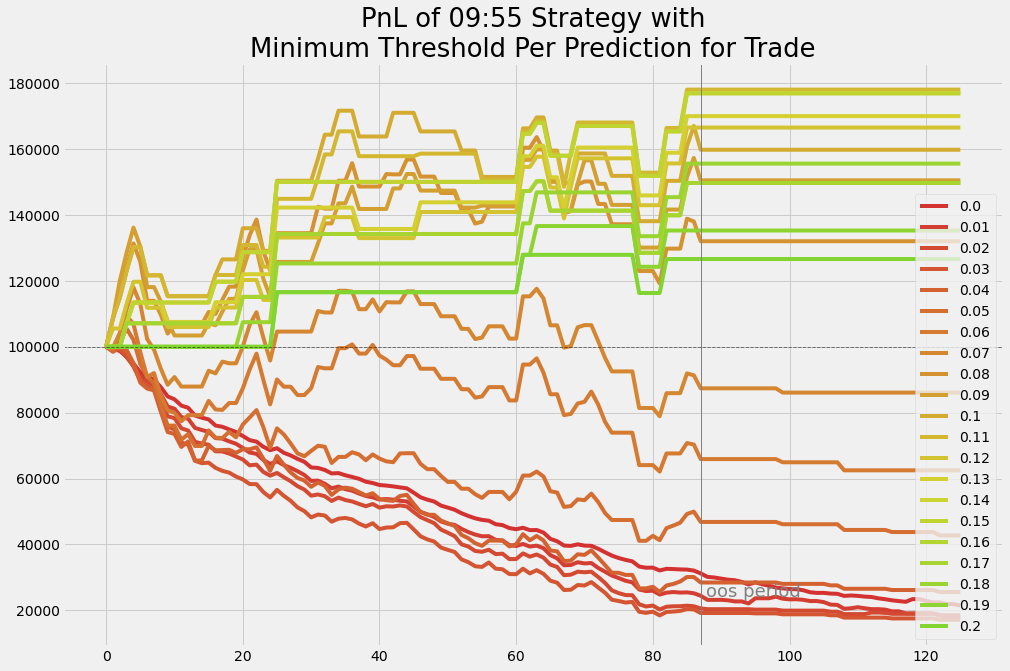

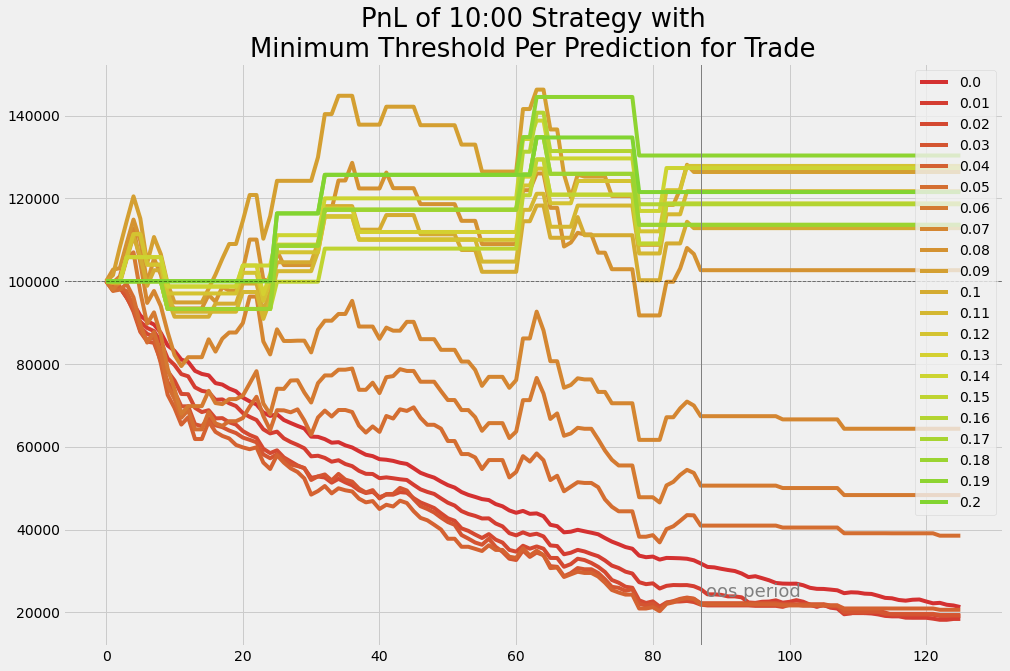

In [194]:
for bt_result in bt_results_per_exit_time:
    rgbs = [hsv_to_rgb((h, .77, .83)) for h in np.linspace(0.0000001, 0.25, len(bt_result))]
    exit_time = None
    for bt_result_dfs, color in zip(bt_result, rgbs):
        if bt_result_dfs is None:
            continue
        if exit_time is None:
            exit_time = bt_result_dfs[0].loc['exit_time'].values[0]
        min_thresh = bt_result_dfs[0].columns[0]
        pnl_per_day = bt_result_dfs[2]
        pd.Series(pnl_per_day, name=min_thresh).plot(color=color)
    
    dates_of_test = bt_result[0][1].index.get_level_values(0).unique()
    oos_start_idx = dates_of_test.get_loc(test_start_date)
    plt.axvline(oos_start_idx, linewidth=1, color='grey')
    plt.text(0.71, 0.05,'oos period', color='grey',
             horizontalalignment='center',verticalalignment='center',
             transform = ax.transAxes
            )
    plt.legend()
    plt.axhline(100_000, color='black', alpha=0.5, linewidth=.9, linestyle='--')
    plt.title(f'PnL of {exit_time.strftime("%H:%M")} Strategy with\nMinimum Threshold Per Prediction for Trade');
#     save_plt_as_png(f'pnl_of_{exit_time.strftime("%H:%M")}_strategy')
    plt.show();


Number of stocks above thresh per day

In [103]:
just_profitable_strategy_profile = bt_results_per_exit_time[0][-17][0].copy()
just_profitable_strategy_profile.columns = [f'min trading thresh: {just_profitable_strategy_profile.columns[0]}']
# save_html_to_png(just_profitable_strategy_profile, 'just_profitable_strategy_profile')
just_profitable_strategy_profile

Generating to ../imgs/just_profitable_strategy_profile.png...
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,min trading thresh: 0.04
init_capital,100000
ending_capital,110086.723491
net_return,0.100867
avg_positions_per_day,0.904
slippage_long,0.01
slippage_short,0.01
avg_locate_fee_per_short_per_share,0.05
sharpe,0.437414
max_drawdown,-0.189607
slippage_and_comm,12542.354597


In [102]:
just_profitable_strategy_trades_list = bt_results_per_exit_time[0][-17][1].round(3)

# save_html_to_png(just_profitable_strategy_trades_list.head(10), 'just_profitable_strategy_trades_list')
just_profitable_strategy_trades_list

Generating to ../imgs/just_profitable_strategy_trades_list.png...
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


ret  trade_ret  predicted_ret    mae  direction  pos_size  \
2021-04-06 SJ    0.146     -0.092         -0.047  0.025       -1.0     -1330   
           PHUN  0.009      0.105          0.073  0.023        1.0      7387   
           ACY   0.116      0.063          0.049  0.060        1.0       942   
           EVAX  0.100     -0.094         -0.055  0.019       -1.0     -1740   
           PLBY  0.045     -0.083         -0.052  0.000       -1.0      -283   
...                ...        ...            ...    ...        ...       ...   
2021-08-05 SITM  0.157      0.028          0.044  0.009        1.0       171   
           GOGO  0.057      0.047          0.040  0.013        1.0      1798   
           STAA  0.088      0.115          0.075  0.008        1.0       113   
2021-08-06 KAVL  0.133     -0.016         -0.043  0.000       -1.0     -3710   
           MVST  0.005     -0.078         -0.043  0.010       -1.0     -1725   

                 pos_amount  ending_position_capital  slippage_and_comm  
2021-04-06 SJ      19790.40                17908.252             66.649  
           PHUN    15882.05                17553.267              0.022  
           ACY     12726.42                13533.089              0.135  
           EVAX    10213.80                 9164.287             87.059  
           PLBY     8178.70                 7488.152             14.439  
...                     ...                      ...                ...  
2021-08-05 SITM    26865.81                27614.197              1.571  
           GOGO    20317.40                21271.586              0.113  
           STAA    15184.94                16925.386              1.344  
2021-08-06 KAVL    27825.00                27186.953            185.575  
           MVST    20941.50                19230.334             86.371  

[113 rows x 9 columns]

Now we plot the sharpe ratio profile across all strategies which exit at 9:35.

In [104]:
sharpes = []
for b in bt_results_per_exit_time[0]:
    if b is None:
        continue
    pred_thresh_to_trade = b[0].columns[0]
    sharpe = b[0].loc['sharpe'].values[0]
    sharpes.append((pred_thresh_to_trade, sharpe))

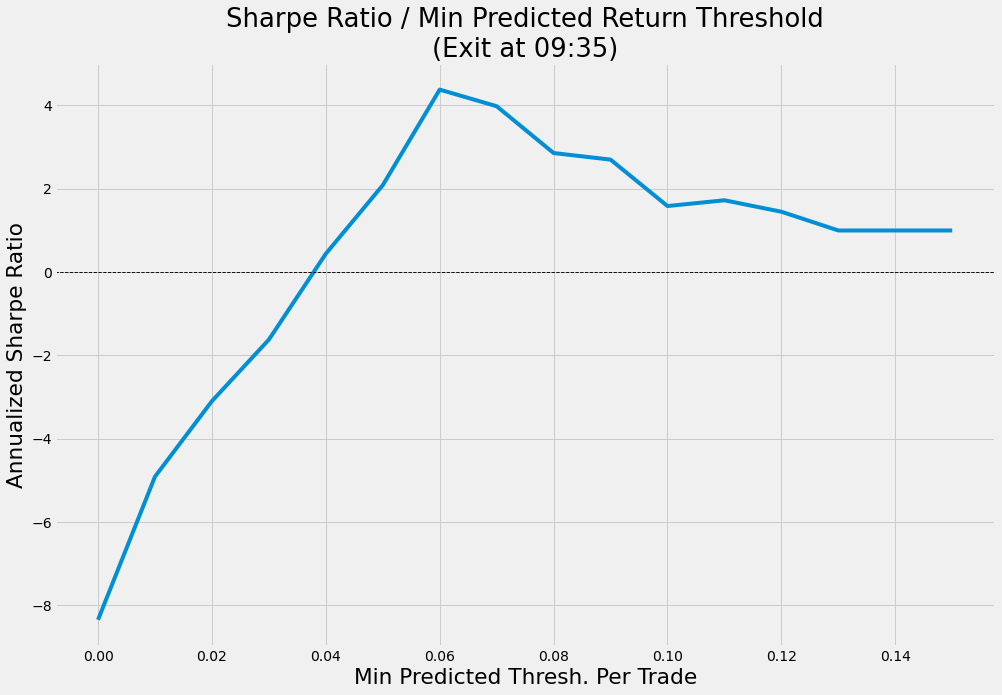

In [105]:
ax = plt.subplot()
pd.DataFrame(sharpes).set_index(0).plot(legend=None, ax=ax)
ax.set_xlabel('Min Predicted Thresh. Per Trade');
ax.set_ylabel('Annualized Sharpe Ratio');
plt.axhline(0, color='black', linewidth=.9, linestyle='--')
plt.title('Sharpe Ratio / Min Predicted Return Threshold\n(Exit at 09:35)');

# save_plt_as_png('sharpe_ratio_to_min_predicted_return_threshold_09:35')

In [ ]:
min_pred_thresh_for_trade = 0.05

y1[y_predicted < -1 * min_pred_thresh_for_trade].groupby(level=0).size().plot(
    color='r', label=f'number of predictions under {min_pred_thresh_for_trade}'
)
y1[y_predicted > min_pred_thresh_for_trade].groupby(level=0).size().plot(
    color='b', label=f'number of predictions above {min_pred_thresh_for_trade}'
)
plt.legend();

In [ ]:
y1[y_predicted < -1 * min_pred_thresh_for_trade].groupby(level=0).size().plot(
    color='r', label=f'number of predictions under {min_pred_thresh_for_trade}'
)
y1[y_predicted > min_pred_thresh_for_trade].groupby(level=0).size().plot(
    color='b', label=f'number of predictions above {min_pred_thresh_for_trade}'
)
plt.legend();

<AxesSubplot:ylabel='Density'>

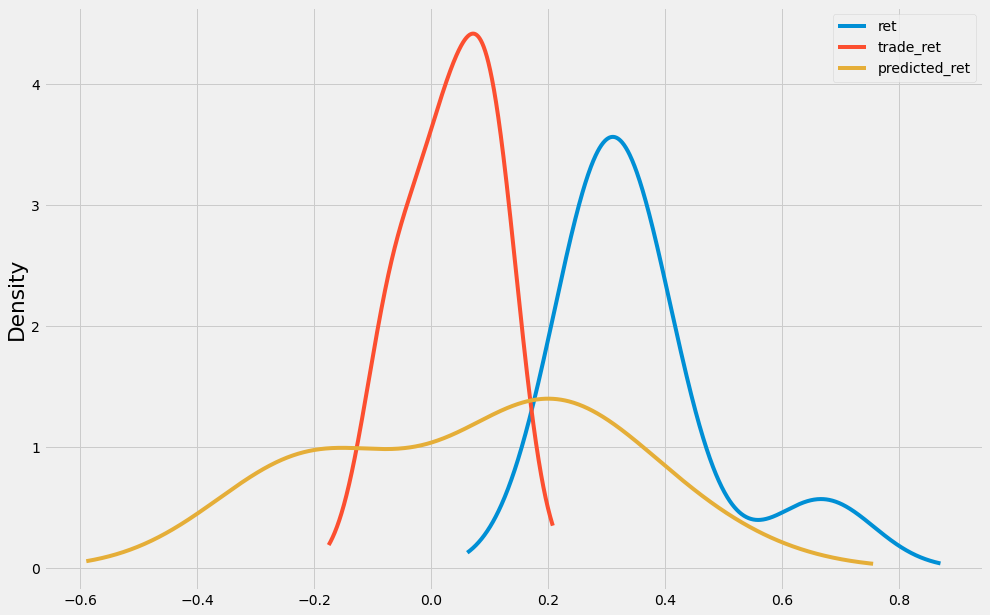

In [674]:
#  not in report
trade_stats_df = bt_results_per_exit_time[0][-5][1]
trade_stats_df[['ret', 'trade_ret', 'predicted_ret']].plot.kde()